In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx

import pynwb
from pynwb import get_class
from pynwb import register_class
from pynwb.form.utils import docval, getargs, popargs, call_docval_func

from datetime import datetime
from dateutil import tz

import matplotlib.pyplot as plt

### Build the track in NetworkX

In [2]:
# Initialize a graph
G = nx.Graph(name='w-track')

# Add nodes to the graph
# ----------------------
# Segments
G.add_node('L', coords=[(1.6, 2.2), (1.6, 0.65)], intermediate_coords=None, kind='segment')
G.add_node('LC', coords=[(1.6, 0.65), (1.9, 0.65)], intermediate_coords=None, kind='segment')  
G.add_node('C', coords=[(1.9, 0.65), (1.9, 2.2)], intermediate_coords=None, kind='segment')  
G.add_node('RC', coords=[(1.9, 0.65), (2.2, 0.65)], intermediate_coords=None, kind='segment')  
G.add_node('R', coords=[(2.2, 0.65), (2.2, 2.2)], intermediate_coords=None, kind='segment')  
G.add_node('EH', coords=[(1.9, 0.4), (1.9, 0.65)], intermediate_coords=None, kind='segment')
# Points
G.add_node('LW', coords=[(1.6, 2.2)], kind='point')
G.add_node('CW', coords=[(1.9, 2.2)], kind='point')
G.add_node('RW', coords=[(2.2, 2.2)], kind='point')
G.add_node('CP', coords=[(1.9, 0.65)], kind='point')
G.add_node('SBD', coords=[(1.9, 0.4)], kind='point')
# Polygon areas
G.add_node('SB', coords=[(1.8, 0.4), (1.9, 0.4), (2.0, 0.4), (2.0, 0.0), (1.8, 0.0)], 
           interior_coords=None, kind='polygon')

# Add edges connecting the appropriate nodes
# -----------------------------------------
# Segment <-> Segment       (Segs must share a coord)
G.add_edge('L', 'LC')
G.add_edge('RC', 'R')
# Segment <-> Well (Point)  (Seg must share a coord with the well)
G.add_edge('L', 'LW')
G.add_edge('C', 'CW')
G.add_edge('R', 'RW')
# Choice Point (Point) <-> Segments  (Seg must share a coord with the choice point)
G.add_edge('CP', 'C')
G.add_edge('CP', 'LC')
G.add_edge('CP', 'RC')
G.add_edge('CP', 'EH')
# Door (Point) <-> Segment  (Segment must share a coord with the door)
G.add_edge('SBD', 'EH')
# Polygon <-> Door (Point)  (Area must share a coord with the door)
G.add_edge('SB', 'SBD')

### Plot the track topology from NetworkX

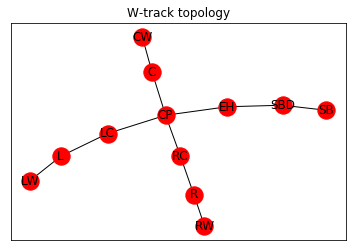

In [3]:
ax = plt.subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title("W-track topology")
nx.draw_networkx(G, fontsize=6)
pass

### Plot geometry from NetworkX

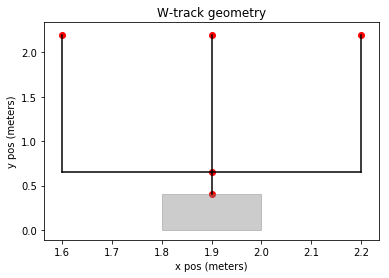

In [4]:
ax = plt.subplot(111)
plt.title('W-track geometry')
for n, attrs in list(G.nodes.data()):
    if attrs['kind']=='point':
        coord = attrs['coords'][0]
        plt.scatter([coord[0]], [coord[1]], color='r')
    elif attrs['kind']=='segment':
        start, end = attrs['coords']
        plt.plot([start[0], end[0]], [start[1], end[1]], color='k')
    elif attrs['kind']=='polygon':
        poly = attrs['coords']
        xs = [e[0] for e in poly]
        ys = [e[1] for e in poly]
        plt.fill(xs, ys, color='grey', alpha=0.4)
    else:
        raise TypeError("Nodes must have 'kind' point, segment, or polygon.")
plt.xlabel('x pos (meters)')
plt.ylabel('y pos (meters)')
pass 

### Load extension and get Python classes for the FL_ApparatusNodes

Note that the get_class() methods turn all parameters into type list/tuple/dict/set. 
This works for Nodes, since they just have coords that we can view as a list of (x, y) 
tuples as a convention. It also works for Edges, which we can view as a list of two Nodes
as convention. However, we might want to write our own Python classes at some
point to enforce the behavior we want, instead of just using named lists for these parameters.

In [5]:
ns_path = "franklab.namespace.yaml"
pynwb.load_namespaces(ns_path)

# If I get a class for the parent FL_ApparatusNode class, then we get a recursion error when trying to instantiate
# objects of the child classes (e.g. FL_PointNode). Why is this?? This prevents us from referencing the parent class.
# FL_ApparatusNode = get_class('FL_ApparatusNode', 'franklab') 

FL_PointNode = get_class('FL_PointNode', 'franklab')
FL_SegmentNode = get_class('FL_SegmentNode', 'franklab')
FL_PolygonNode = get_class('FL_PolygonNode', 'franklab')

FL_ApparatusEdge = get_class('FL_ApparatusEdge', 'franklab') 

### Make a Python class for FL_ApparatusGraph

As mentioned above, the get_class() method turns all parameters into type list/tuple/dict/set. For FL_ApparatusGraph, we have a nodes list and an edge list, so we could again just allow these to be named lists. However, we want to include some enforcement of properties on this graph, such as making sure all nodes are of type FL_BehavioralNode, and requiring all edges to contain only nodes in the nodes list. To do this, I will write my own Python class implementing the FL_ApparatusGraph spec.

In [6]:
@register_class('FL_ApparatusGraph', 'franklab')
class FL_ApparatusGraph(pynwb.core.NWBDataInterface):
    """
    Graph of FL_ApparatusNodes connected by undirected FL_ApparatusEdges.
    Represents behaviorally reachable components of an apparatus.
    """
    
    __nwbfields__ = (
        'name',
        'description',
        'nodes',
        'edges'
    )
    
    
    @docval({'name': 'name', 'type': str, 'doc': 'Name of this FL_ApparatusGraph', 'default': 'FL_ApparatusGraph'},
            {'name': 'description', 'type': str, 'doc': 'a description of this FL_ApparatusGraph', 'default': ""},
            {'name': 'nodes', 'type': list, 'doc': 'list of FL_ApparatusNodes to initialize the graph with', 'default': None},
            {'name': 'edges', 'type': list, 
             'doc': 'list of edges (tuples of node names) to initialize the graph with', 'default': None})
    def __init__(self, **kwargs):
        call_docval_func(super(FL_ApparatusGraph, self).__init__, kwargs)
        if not kwargs['nodes']:
            self.nodes = []
        else:
            assert(all([isinstance(n, FL_ApparatusNode) for n in nodes]))
            self.nodes = kwargs['nodes']
        
        if not kwargs['edges']:
            self.edges = []
        else:
            assert(all([e in nodes for e in edges]))
            self.edges = kwargs['edges']
            
        
    def add_edge(self, edge):
        """
        Add an undirected edge to the edge list. Both nodes must already be in the nodes list.
        """
        if not isinstance(edge, FL_ApparatusEdge):
            raise TypeError("Edge must be of type FL_ApparatusEdge")
            
        node_names = [n.name for n in self.nodes]
        if edge.nodes[0] not in node_names or edge.nodes[1] not in node_names:
            raise ValueError("Error adding edge " + edge.name + ". Both nodes in the edge must already be in the nodes list.")
            
        self.edges.append(edge)
        
        
    def add_node(self, node):
        """
        Add a node to the nodes list.
        """
        if not (isinstance(node, FL_PointNode) or 
                isinstance(node, FL_SegmentNode) or 
                isinstance(node, FL_PolygonNode)):
            raise TypeError("Node must be of type FL_ApparatusNode")
            
        self.nodes.append(node)

### Function for converting from NX nodes to FL_ApparatusNodes

In [7]:
def nx_to_fl_node(node_name, attrs, apparatus):
    if 'kind' not in attrs:
        raise TypeError("NX node attributes must contain a 'kind' field")
    if 'coords' not in attrs:
        raise TypeError("NX node attributes must contain a 'coords' field")
    if attrs['kind']=='segment':
        if 'intermediate_coords' not in attrs:
            raise TypeError("NX 'segment' nodes must contain a 'intermediate_coords' field. It can be set to None.")
        return FL_SegmentNode(name=node_name, coords=attrs['coords'], 
                              intermediate_coords=attrs['intermediate_coords'], parent=apparatus)
    elif attrs['kind']=='point':
        return FL_PointNode(name=n, coords=attrs['coords'], parent=apparatus)
    elif attrs['kind']=='polygon':
        if 'interior_coords' not in attrs:
            raise TypeError("NX 'polygon' nodes must contain a 'interior_coords' field. It can be set to None.")
        return FL_PolygonNode(name=n, coords=attrs['coords'], 
                              interior_coords=attrs['interior_coords'], parent=apparatus)
    else:
        raise TypeError('Nodes must be of type point, segment, or polygon.')

### Load NetworkX nodes into FL_ApparatusNode objects and add to the FL_ApparatusGraph

In [8]:
appar = FL_ApparatusGraph(name='W-track with sleep box')
for n, attrs in list(G.nodes.data()):
    fl_node = nx_to_fl_node(n, attrs, appar)
    appar.add_node(fl_node)

### Load NetworkX edges into FL_ApparatusEdge objects

In [9]:
for (n1, n2) in G.edges:
    name_str = n1 + '-' + n2
    appar.add_edge(FL_ApparatusEdge(name=name_str, nodes=[n1, n2], parent=appar))

### Create a new NWBfile

In [10]:
anim = 'Bon' 
day = 4 # below we'll code date as 2006-Jan-'Day'
day_str = '%02d' % day
dataset_zero_time = datetime(2006, 1, day, 12, 0, 0, tzinfo=tz.gettz('US/Pacific'))
file_create_date = datetime.now(tz.tzlocal())
nwb_filename = 'apparatus_extension_test.nwb'

nwbf = pynwb.NWBFile(
           session_description='Example NWBFile with behavioral track data',
           identifier=anim+day_str,
           session_start_time=dataset_zero_time,
           file_create_date=file_create_date,
           lab='Frank Laboratory',
           experimenter='Mattias Karlsson',
           institution='UCSF',
           experiment_description='Recordings from awake behaving rat')

### Add the FL_ApparatusGraph into the NWBFile
Here we add it as a data interface of a processing module called 'Behavior', even though the docs state that data interfaces should be used for containers that do not include metadata. (https://pynwb.readthedocs.io/en/latest/building_api.html#nwbdatainterface)

In [11]:
behav_mod = nwbf.create_processing_module(name='Behavior', 
                                          description='Behavioral data and metadata')
behav_mod.add_data_interface(appar, 'W-track')


W-track with sleep box <class '__main__.FL_ApparatusGraph'>
Fields:
  edges: [
L-LC <class 'abc.FL_ApparatusEdge'>
Fields:
 
L-LW <class 'abc.FL_ApparatusEdge'>
Fields:
 
LC-CP <class 'abc.FL_ApparatusEdge'>
Fields:
 
C-CW <class 'abc.FL_ApparatusEdge'>
Fields:
 
C-CP <class 'abc.FL_ApparatusEdge'>
Fields:
 
RC-R <class 'abc.FL_ApparatusEdge'>
Fields:
 
RC-CP <class 'abc.FL_ApparatusEdge'>
Fields:
 
R-RW <class 'abc.FL_ApparatusEdge'>
Fields:
 
EH-CP <class 'abc.FL_ApparatusEdge'>
Fields:
 
EH-SBD <class 'abc.FL_ApparatusEdge'>
Fields:
 
SBD-SB <class 'abc.FL_ApparatusEdge'>
Fields:
]
  nodes: [
L <class 'abc.FL_SegmentNode'>
Fields:
 
LC <class 'abc.FL_SegmentNode'>
Fields:
 
C <class 'abc.FL_SegmentNode'>
Fields:
 
RC <class 'abc.FL_SegmentNode'>
Fields:
 
R <class 'abc.FL_SegmentNode'>
Fields:
 
EH <class 'abc.FL_SegmentNode'>
Fields:
 
LW <class 'abc.FL_PointNode'>
Fields:
 
CW <class 'abc.FL_PointNode'>
Fields:
 
RW <class 'abc.FL_PointNode'>
Fields:
 
CP <class 'abc.FL_PointNode

### Write the NWBfile

In [12]:
# Write
with pynwb.NWBHDF5IO(nwb_filename, mode='w') as iow:
    iow.write(nwbf, cache_spec=True)
print('Wrote nwb file: ' + nwb_filename)

/Users/ericmiller/Src/pynwb/src/pynwb/form/build/map.py:881: MissingRequiredWarning: attribute 'help' for 'W-track with sleep box' (FL_ApparatusGraph)
  warnings.warn(msg, MissingRequiredWarning)


Wrote nwb file: apparatus_extension_test.nwb


### Read the NWBFile

In [13]:
# Read
io = pynwb.NWBHDF5IO(nwb_filename, mode='r', load_namespaces=True)
nwbf_read = io.read()
print('Finished reading nwb file: ' + nwb_filename)

Finished reading nwb file: apparatus_extension_test.nwb


/Users/ericmiller/Src/pynwb/src/pynwb/form/spec/namespace.py:425: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/Users/ericmiller/Src/pynwb/src/pynwb/form/spec/namespace.py:425: UserWarning: ignoring namespace 'franklab' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


### Make sure our FL_ApparatusGraph is still looking good

In [ ]:
appar = nwbf_read.modules['Behavior']['W-track']
print(appar)

### Function to directly input FL_ApparatusNodes into an NX graph

In [ ]:
def add_fl_node_to_nx_graph(fl_node, nx_graph):
    if isinstance(fl_node, FL_SegmentNode):
        nx_graph.add_node(fl_node.name, coords=fl_node.coords, intermediate_coords=fl_node.intermediate_coords)
    elif isinstance(fl_node, FL_PointNode):
        nx_graph.add_node(fl_node.name, coords=fl_node.coords)
    elif isinstance(fl_node, FL_PolygonNode):
        nx_graph.add_node(fl_node.name, coords=fl_node.coords, interior_coords=fl_node.interior_coords)
    else:
        raise TypeError("'fl_node' must be of type FL_SegmentNode, FL_PointNode, or FL_PolygonNode")

### Extract graph data back out into NetworkX

In [ ]:
appar = nwbf_read.modules['Behavior']['W-track']
H = nx.Graph(name='w-track round trip')

for n in appar.nodes:
    add_fl_node_to_nx_graph(n, H)

for e in appar.edges:
    (n1, n2) = e.nodes
    H.add_edge(n1, n2)

### Plot track topology from NetworkX (roundtrip)

In [ ]:
ax = plt.subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title("W-track topology")
nx.draw_networkx(H, fontsize=6)
pass

### Plot track geometry from NetworkX (roundtrip)

In [ ]:
ax = plt.subplot(111)
plt.title('W-track geometry')
for n, attrs in list(H.nodes.data()):
    if attrs['kind']=='point':
        coord = attrs['coords'][0]
        plt.scatter([coord[0]], [coord[1]], color='r')
    elif attrs['kind']=='segment':
        start, end = attrs['coords']
        plt.plot([start[0], end[0]], [start[1], end[1]], color='k')
    elif attrs['kind']=='polygon':
        poly = attrs['coords']
        xs = [e[0] for e in poly]
        ys = [e[1] for e in poly]
        plt.fill(xs, ys, color='grey', alpha=0.4)
    else:
        raise TypeError("Nodes must have 'kind' point, segment, or polygon.")
plt.xlabel('x pos (meters)')
plt.ylabel('y pos (meters)')
pass 

In [ ]:
io.close()  # Close the reading file IO